In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt

from skimage import measure

import albumentations as A
import sys
sys.path.append('..')
from modules.augmentation import *

# Split Object Building

In [2]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [3]:
result = 'oba'

img_dir = os.path.join(result, 'images')
os.makedirs(img_dir, exist_ok=True)

mask_dir = os.path.join(result, 'masks')
os.makedirs(mask_dir, exist_ok=True)

In [4]:
df = pd.read_csv('./train2.csv')

In [5]:
def split_mask(image, mask, labels):
    global counter
    for i in range(1, labels.max()+1):
        object_mask = (labels == i).astype(np.uint8)

        if object_mask.sum() < 1000:
            continue

        rows, cols = np.where(object_mask == 1)
        cutout_mask = object_mask[min(rows):max(rows), min(cols):max(cols)]
        cutout_image = image[min(rows):max(rows), min(cols):max(cols)]

        if (min(rows) == 0 or max(rows) == mask.shape[0]-1 or 
            min(cols) == 0 or max(cols) == mask.shape[1]-1):
            continue

        cv2.imwrite(os.path.join(img_dir, f'{counter}.png'), cutout_image)
        cv2.imwrite(os.path.join(mask_dir, f'{counter}.png'), cutout_mask)

        counter += 1

In [6]:
counter = 0

for idx in tqdm(range(len(df))):
    img_path = os.path.join('train_img', os.path.basename(df.iloc[idx]['img_path']))
    mask_rle = df.iloc[idx]['mask_rle']

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

    labels = measure.label(mask)

    split_mask(image, mask, labels)

100%|██████████| 7140/7140 [17:11<00:00,  6.92it/s]


In [7]:
len(glob(os.path.join(img_dir, "*.png")))

84830

# Get Background

In [8]:
result_dir = './oba/background_512'
os.makedirs(result_dir, exist_ok=True)

In [9]:
global num

def divide_img(filename, image, mask, stride=200, size=224):
    global num
    for a in range(0, 1024-size+1, stride):
        for b in range(0, 1024-size+1, stride):
            image_resized = image[a:a+size, b:b+size, :]
            mask_resized = mask[a:a+size, b:b+size]
            
            if mask_resized.sum() == 0:
                cv2.imwrite(os.path.join(result_dir, f'{num}_{filename.replace(".png", "")}.png'), image_resized)
                num += 1

In [10]:
num = 0
for idx in tqdm(range(len(df))):
    filename = os.path.basename(df.iloc[idx]['img_path'])
    
    img_path = os.path.join('train_img', filename)
    mask_rle = df.iloc[idx]['mask_rle']
    
    image = cv2.imread(img_path)
    mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

    divide_img(filename=filename,
               image=image, 
               mask=mask, 
               stride=256, 
               size=512)

100%|██████████| 7140/7140 [02:43<00:00, 43.70it/s]


In [11]:
len(glob(os.path.join(result_dir, "*.png")))

3977

# Merge

In [12]:
object_transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
])

bg_transform = A.Compose([
    A.Rotate(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),

    A.OneOf([
        VerticalMirrorUp(1),
        VerticalMirrorDown(1),
    ], p=0.5),

    A.OneOf([
        HorizontalMirrorUp(1),
        HorizontalMirrorDown(1),
    ], p=0.5),
])

In [13]:
result = 'oba'
img_dir = os.path.join(result, 'images')
mask_dir = os.path.join(result, 'masks')
bg_dir = os.path.join(result, 'background_512')

object_images = sorted(glob(os.path.join(img_dir, "*.png")))
object_masks = sorted(glob(os.path.join(mask_dir, "*.png")))
backgrounds = sorted(glob(os.path.join(bg_dir, "*.png")))

print(len(object_images), len(backgrounds))

84830 3977


In [14]:
output_dir = os.path.join(result, 'result2')
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'masks'), exist_ok=True)

In [15]:
for i in tqdm(range(20000)):
    obj_list = []

    for _ in range(np.random.randint(10, 20)):
        idx = np.random.randint(len(object_images))

        image = cv2.imread(object_images[idx])
        mask = cv2.imread(object_masks[idx], cv2.IMREAD_GRAYSCALE)

        object_img = cv2.bitwise_and(image, image, mask=mask)

        transformed = object_transform(image=object_img, mask=mask)
        image = transformed['image']
        mask = transformed['mask']
        
        if mask.shape[1] >= 512 or mask.shape[0] >= 512:
            image = cv2.resize(image, (mask.shape[1]//2, mask.shape[0]//2))
            mask = cv2.resize(mask, (mask.shape[1]//2, mask.shape[0]//2))
        
        obj_list.append({'image': image, 'mask': mask})

    b_idx = np.random.randint(len(backgrounds))
    background = cv2.imread(backgrounds[b_idx])

    transformed = bg_transform(image=background)
    background = transformed['image']

    background_mask = np.zeros(background.shape[:-1])

    shadow_x_offset = np.random.randint(-7, 7)
    shadow_y_offset = np.random.randint(-7, 7)

    occupied_regions = []

    for obj in obj_list:
        image, mask = obj['image'], obj['mask']

        shadow = np.zeros_like(image)
        h, w = mask.shape

        try:
            x_offset = np.random.randint(512 - w)
            y_offset = np.random.randint(512 - h)
        except:
            continue

        overlap = True
        attempts = 0
        while overlap and attempts < 10:
            overlap = any((x <= x_offset <= x + w or x <= x_offset + w <= x + w) and 
                        (y <= y_offset <= y + h or y <= y_offset + h <= y + h) 
                        for x, y, w, h in occupied_regions)
            if overlap:
                x_offset = np.random.randint(512 - w)
                y_offset = np.random.randint(512 - h)
            attempts += 1

        if attempts == 10:
            continue

        occupied_regions.append((x_offset, y_offset, w, h))

        roi = background[y_offset:y_offset+h, x_offset:x_offset+w]
        roi = cv2.copyTo(shadow, mask, roi)

        shadow_y_start = max(y_offset + shadow_y_offset, 0)
        shadow_y_end = min(y_offset + shadow_y_offset + h, background.shape[0])

        shadow_x_start = max(x_offset + shadow_x_offset, 0)
        shadow_x_end = min(x_offset + shadow_x_offset + w, background.shape[1])

        background[shadow_y_start:shadow_y_end, shadow_x_start:shadow_x_end] = roi[:shadow_y_end - shadow_y_start, :shadow_x_end - shadow_x_start]

        roi = background[y_offset:y_offset+h, x_offset:x_offset+w]
        roi = cv2.copyTo(image, mask, roi)
        background[y_offset:y_offset+h, x_offset:x_offset+w] = roi
        background_mask[y_offset:y_offset+h, x_offset:x_offset+w] += mask
        background_mask = (background_mask >= 1.0).astype(np.uint8)

    cv2.imwrite(os.path.join(output_dir, 'images', f'oba_{i}.png'), background)
    cv2.imwrite(os.path.join(output_dir, 'masks', f'oba_{i}.png'), background_mask)

100%|██████████| 20000/20000 [06:31<00:00, 51.04it/s]


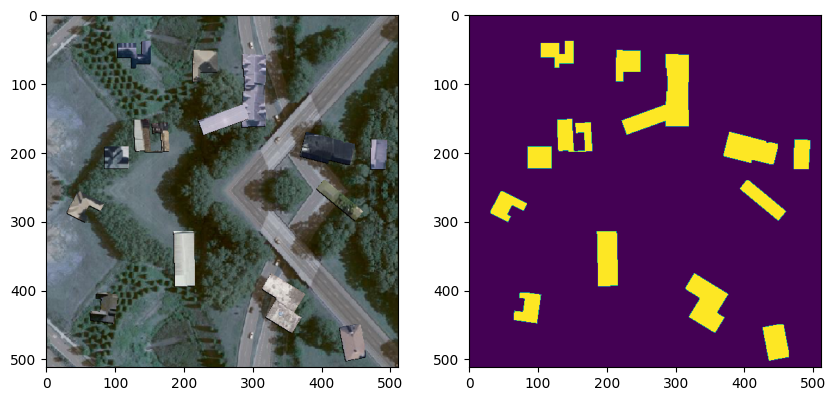

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].imshow(background)
axes[1].imshow(background_mask)
plt.show()